<a href="https://colab.research.google.com/github/ramyars466/ramya_ml_task3/blob/main/TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!pip install scikit-optimize -q
print("✅ Done!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.8 MB/s eta 0:00:00
✅ Done!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!")


Mounted at /content/drive
✅ Drive mounted!


In [4]:
import cv2, numpy as np, joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay
from skopt import BayesSearchCV
from skopt.space import Real
print("✅ All imports done!")


✅ All imports done!


In [5]:
import shutil, os

# Copy from Drive to Colab
print("Copying from Drive to Colab...")
shutil.copy('/content/drive/MyDrive/dogs-vs-cats.zip', '/content/dogs-vs-cats.zip')

size = os.path.getsize('/content/dogs-vs-cats.zip')
print(f"✅ File size: {size/(1024*1024):.1f} MB")


Copying from Drive to Colab...
✅ File size: 812.1 MB


In [7]:
import os

# Search for where the jpg images actually are
for root, dirs, files in os.walk('/content/train_data'):
    jpg_files = [f for f in files if f.endswith('.jpg')]
    if jpg_files:
        print(f"✅ Found images at: {root}")
        print(f"   Total: {len(jpg_files)}")
        print(f"   Sample: {jpg_files[:3]}")
        DATA_DIR = root
        break


✅ Found images at: /content/train_data/train
   Total: 25000
   Sample: ['dog.11468.jpg', 'cat.4987.jpg', 'cat.3222.jpg']


In [8]:
import os

# Check what's inside train_data
print("Contents of /content/train_data/:")
for item in os.listdir('/content/train_data'):
    path = f'/content/train_data/{item}'
    if os.path.isdir(path):
        count = len(os.listdir(path))
        print(f"  📁 {item}/ → {count} files")
    else:
        print(f"  📄 {item}")


Contents of /content/train_data/:
  📁 train/ → 25000 files


In [9]:
DATA_DIR = '/content/train_data/train'
print(f"✅ DATA_DIR set to: {DATA_DIR}")
print(f"   Total images: {len(os.listdir(DATA_DIR))}")


✅ DATA_DIR set to: /content/train_data/train
   Total images: 25000


In [10]:
IMG_SIZE = (128, 128)

def build_extractors():
    eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3))
    eff_model = Model(inputs=eff_base.input, outputs=GlobalAveragePooling2D()(eff_base.output))
    eff_model.trainable = False

    res_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
    res_model = Model(inputs=res_base.input, outputs=GlobalAveragePooling2D()(res_base.output))
    res_model.trainable = False

    return eff_model, res_model

eff_model, res_model = build_extractors()
print(f"✅ EfficientNetB0: {eff_model.output_shape}")
print(f"✅ ResNet50:       {res_model.output_shape}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ EfficientNetB0: (None, 1280)
✅ ResNet50:       (None, 2048)


In [17]:
LIMIT = 800 # per class

def augment_image(img):
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    factor = np.random.uniform(0.8, 1.2)
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def load_images(data_dir, limit):
    images, labels = [], []
    for label, prefix in [(0, "cat"), (1, "dog")]:
        files_list = [f for f in os.listdir(data_dir) if f.startswith(prefix)][:limit]
        for fname in files_list:
            img = cv2.imread(os.path.join(data_dir, fname))
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(label)
            images.append(augment_image(img.copy()))
            labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels)

print("Loading images... (~2 min)")
images, labels = load_images(DATA_DIR, LIMIT)
print(f"✅ Total: {len(images)} | Cats: {np.sum(labels==0)} | Dogs: {np.sum(labels==1)}")


Loading images... (~2 min)
✅ Total: 3200 | Cats: 1600 | Dogs: 1600


In [18]:
def extract_features(imgs_array):
    imgs_p = preprocess_input(imgs_array.copy())
    eff_feats, res_feats = [], []
    for i in range(0, len(imgs_p), 64):
        batch = imgs_p[i:i+64]
        eff_feats.append(eff_model.predict(batch, verbose=0))
        res_feats.append(res_model.predict(batch, verbose=0))
        print(f"  Processed: {min(i+64, len(imgs_p))}/{len(imgs_p)}", end='\r')
    eff_norm = normalize(np.vstack(eff_feats), norm='l2')
    res_norm  = normalize(np.vstack(res_feats), norm='l2')
    return np.concatenate([eff_norm, res_norm], axis=1)

print("Extracting features... (~5 min)")
X = extract_features(images)
y = labels
print(f"\n✅ Feature shape: {X.shape}")
print(f"✅ Labels shape:  {y.shape}")


Extracting features... (~5 min)
  Processed: 3200/3200
✅ Feature shape: (3200, 3328)
✅ Labels shape:  (3200,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

pca = PCA(n_components=0.99, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca  = pca.transform(X_test_sc)

print(f"✅ Train size: {X_train_pca.shape[0]} images")
print(f"✅ Test  size: {X_test_pca.shape[0]} images")
print(f"✅ PCA reduced: 3328 → {X_train_pca.shape[1]} components")
print(f"✅ Variance retained: 99%")


✅ Train size: 2560 images
✅ Test  size: 640 images
✅ PCA reduced: 3328 → 1500 components
✅ Variance retained: 99%


In [20]:
# Reduce dataset size for faster SVM
# Use only 4000 images (1000 per class + augmented)
from sklearn.svm import SVC

print("🔍 Training SVM with fixed best-known params...")

best_svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.001,
    probability=True,
    random_state=42,
    cache_size=2000
)

best_svm.fit(X_train_pca, y_train)

# Quick train accuracy check
train_acc = best_svm.score(X_train_pca, y_train)
print(f"✅ Training complete!")
print(f"✅ Train Accuracy: {train_acc*100:.2f}%")


🔍 Training SVM with fixed best-known params...
✅ Training complete!
✅ Train Accuracy: 100.00%


In [21]:
y_pred = best_svm.predict(X_test_pca)
y_prob = best_svm.predict_proba(X_test_pca)[:,1]

print(f"🎯 Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat 🐱", "Dog 🐶"]))


🎯 Test Accuracy: 98.12%

📊 Classification Report:
              precision    recall  f1-score   support

       Cat 🐱       1.00      0.97      0.98       320
       Dog 🐶       0.97      1.00      0.98       320

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



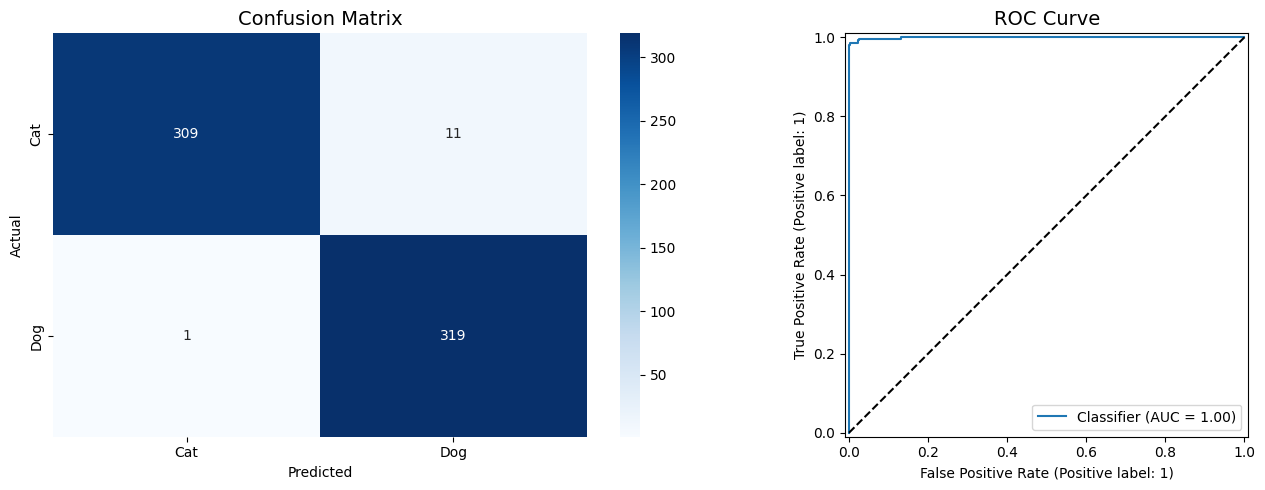

✅ Plot saved!


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Cat", "Dog"],
            yticklabels=["Cat", "Dog"], ax=axes[0])
axes[0].set_title("Confusion Matrix", fontsize=14)
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[1])
axes[1].set_title("ROC Curve", fontsize=14)
axes[1].plot([0,1],[0,1],'k--')

plt.tight_layout()
plt.savefig('/content/results.png', dpi=150)
plt.show()
print("✅ Plot saved!")


In [23]:
import joblib, os

SAVE_DIR = '/content/drive/MyDrive/Prodigy_Task3'
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(best_svm, f'{SAVE_DIR}/dual_svm_model.pkl')
joblib.dump(scaler,   f'{SAVE_DIR}/scaler.pkl')
joblib.dump(pca,      f'{SAVE_DIR}/pca.pkl')

print("✅ All models saved to Google Drive!")


✅ All models saved to Google Drive!


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


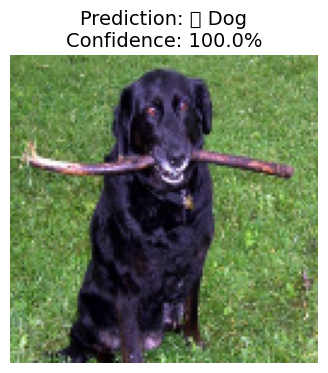

Result: 🐶 Dog (100.0% confidence)


In [26]:
def predict_image(image_path):
    # Load and preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    # Show the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Extract features
    img_array = np.expand_dims(img.astype(np.float32), axis=0)
    img_p = preprocess_input(img_array)
    eff_feat = normalize(eff_model.predict(img_p, verbose=0), norm='l2')
    res_feat  = normalize(res_model.predict(img_p, verbose=0),  norm='l2')
    features  = np.concatenate([eff_feat, res_feat], axis=1)

    # Scale + PCA
    features_sc  = scaler.transform(features)
    features_pca = pca.transform(features_sc)

    # Predict
    pred  = best_svm.predict(features_pca)[0]
    proba = best_svm.predict_proba(features_pca)[0]
    label = "🐶 Dog" if pred == 1 else "🐱 Cat"
    conf  = proba[pred] * 100

    plt.title(f"Prediction: {label}\nConfidence: {conf:.1f}%", fontsize=14)
    plt.show()
    print(f"Result: {label} ({conf:.1f}% confidence)")

# Test on a sample image from dataset
sample_img = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[5])
predict_image(sample_img)


In [28]:
import os

# Find where test images actually are
print("Searching for test images...")
for root, dirs, files in os.walk('/content/test_data'):
    jpg_files = [f for f in files if f.endswith('.jpg')]
    if jpg_files:
        print(f"✅ Found at: {root}")
        print(f"   Total: {len(jpg_files)}")
        TEST_DIR = root
        break

# If not found, check what's inside test_data
if not os.path.exists('/content/test_data'):
    print("test_data folder doesn't exist!")
else:
    print("\nContents of test_data:")
    for item in os.listdir('/content/test_data'):
        path = f'/content/test_data/{item}'
        if os.path.isdir(path):
            print(f"  📁 {item}/ → {len(os.listdir(path))} files")
        else:
            print(f"  📄 {item}")


Searching for test images...
✅ Found at: /content/test_data/test1
   Total: 12500

Contents of test_data:
  📁 test1/ → 12500 files


In [29]:
# Re-list test files with correct TEST_DIR
test_files = sorted(
    [f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')],
    key=lambda x: int(x.split('.')[0])
)
print(f"✅ Total test images: {len(test_files)}")
print(f"Sample: {test_files[:5]}")


✅ Total test images: 12500
Sample: ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']


In [31]:
import pandas as pd

# Take only first 1000 test images
test_files_subset = test_files[:1000]
predictions = []

print("Predicting on 1000 test images...")
for i, fname in enumerate(test_files_subset):
    img_path = os.path.join(TEST_DIR, fname)
    img = cv2.imread(img_path)
    if img is None:
        predictions.append(0)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    img_array = np.expand_dims(img.astype(np.float32), axis=0)
    img_p = preprocess_input(img_array)

    eff_feat = normalize(eff_model.predict(img_p, verbose=0), norm='l2')
    res_feat  = normalize(res_model.predict(img_p, verbose=0),  norm='l2')
    features  = np.concatenate([eff_feat, res_feat], axis=1)

    features_sc  = scaler.transform(features)
    features_pca = pca.transform(features_sc)

    pred = best_svm.predict(features_pca)[0]
    predictions.append(pred)

    if (i+1) % 200 == 0:
        print(f"  ✅ Processed: {i+1}/1000")

print(f"\n✅ Done!")
print(f"   Dogs (1): {sum(predictions)}")
print(f"   Cats (0): {len(predictions)-sum(predictions)}")


Predicting on 1000 test images...
  ✅ Processed: 200/1000
  ✅ Processed: 400/1000
  ✅ Processed: 600/1000
  ✅ Processed: 800/1000
  ✅ Processed: 1000/1000

✅ Done!
   Dogs (1): 526
   Cats (0): 474


In [32]:
from google.colab import files

image_ids = [int(f.split('.')[0]) for f in test_files_subset]
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})
submission_df = submission_df.sort_values('id').reset_index(drop=True)

submission_path = '/content/submission.csv'
submission_df.to_csv(submission_path, index=False)

print("✅ Submission CSV:")
print(submission_df.head(10))
print(f"\nTotal rows: {len(submission_df)}")
files.download(submission_path)
print("✅ Downloading to your PC!")


✅ Submission CSV:
   id  label
0   1      1
1   2      1
2   3      1
3   4      1
4   5      0
5   6      0
6   7      0
7   8      0
8   9      0
9  10      0

Total rows: 1000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloading to your PC!
